In [1]:
import torch
import xarray as xr
import numpy as np

from aurora import Batch, Metadata

from pathlib import Path

download_path = Path("~/downloads/era5")

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

# Load the full EMARS file
ds = xr.open_dataset("emars_v1.0_cntl_memb_MY27_Ls090-120.nc")

# Subset to (?) timesteps and (?) pressure levels (adjust as needed)
ds_subset = ds.isel(time=slice(0, 2), pfull=slice(0, 13))

# Get min and max lat/lon
lat_min = ds_subset.lat.values.min()
lat_max = ds_subset.lat.values.max()
lon_min = ds_subset.lon.values.min()
lon_max = ds_subset.lon.values.max()

new_lat = np.linspace(lat_min, lat_max, 721)
new_lon = np.linspace(lon_min, lon_max, 1440)

ds_interp = ds_subset.interp(lat=new_lat, lon=new_lon)

emars_ds = ds_interp.sortby("lat", ascending=False)

surf_10u = emars_ds['u'].isel(pfull=-1)
surf_10v = emars_ds['v'].isel(pfull=-1)

batch = Batch(
    surf_vars={
        # First select the first two time points: 00:00 and 06:00. Afterwards, `[None]`
        # inserts a batch dimension of size one.
        "2t": torch.from_numpy(emars_ds["ts"].values[:2][None]),
        "10u": torch.from_numpy(surf_10u.values[:2][None]),
        "10v": torch.from_numpy(surf_10v.values[:2][None]),
        "msl": torch.from_numpy(emars_ds["ps"].values[:2][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(emars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(emars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(emars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(emars_ds["vap"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(emars_ds.lat.values),
        lon=torch.from_numpy(emars_ds.lon.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(emars_ds.time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [2]:
# Set to `False` to run locally and to `True` to run on Foundry.
run_on_foundry = False

In [3]:
if not run_on_foundry:
    from aurora import Aurora, rollout

    model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
    model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

    model.eval()
    model = model.to("cuda")

    with torch.inference_mode():
        preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

    model = model.to("cpu")

In [4]:
if run_on_foundry:
    import logging
    import os
    import warnings

    from aurora.foundry import BlobStorageChannel, FoundryClient, submit

    # In this demo, we silence all warnings.
    warnings.filterwarnings("ignore")

    # But we do want to show what's happening under the hood!
    logging.basicConfig(level=logging.WARNING, format="%(asctime)s [%(levelname)s] %(message)s")
    logging.getLogger("aurora").setLevel(logging.INFO)

    foundry_client = FoundryClient(
        endpoint=os.environ["FOUNDRY_ENDPOINT"],
        token=os.environ["FOUNDRY_TOKEN"],
    )
    channel = BlobStorageChannel(os.environ["BLOB_URL_WITH_SAS"])

    predictions = list(
        submit(
            batch,
            model_name="aurora-0.25-pretrained",
            num_steps=2,
            foundry_client=foundry_client,
            channel=channel,
        )
    )

/tmp/ipykernel_23359/1691505199.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


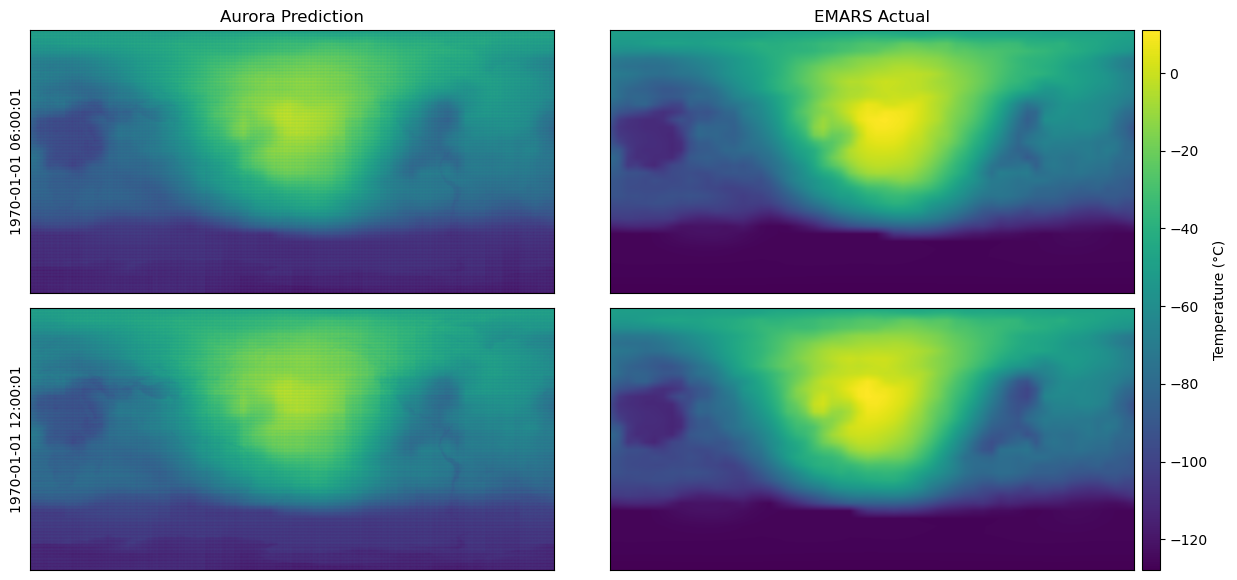

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(2, 2, figsize=(12, 5.9))
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 9, .18], wspace=.05)

for i in range(ax.shape[0]):
    pred = preds[i]

    im1 = ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    im2 = ax[i, 1].imshow(emars_ds["ts"][i].values - 273.15)
    if i == 0:
        ax[i, 1].set_title("EMARS Actual")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

# Add color bar for each row
cbar_ax = fig.add_subplot(gs[:, 2])
cbar = fig.colorbar(im2, cbar_ax)
cbar.set_label("Temperature (°C)")

plt.tight_layout()

In [20]:
# Add color bar for each row
cbar = fig.colorbar(im2, ax=ax[i, :], orientation='vertical')
cbar.set_label("Temperature (°C)")
plt.show()

In [38]:
import torch
import xarray as xr
from pathlib import Path

from aurora import Batch, Metadata

download_path = Path("~/downloads/era5")

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

batch = Batch(
    surf_vars={
        # First select the first two time points: 00:00 and 06:00. Afterwards, `[None]`
        # inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_varssu_ds["t2m"].values[:2][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [39]:
# Set to `False` to run locally and to `True` to run on Foundry.
run_on_foundry = False

In [40]:
if not run_on_foundry:
    from aurora import Aurora, rollout

    model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
    model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

    model.eval()
    model = model.to("cuda")

    with torch.inference_mode():
        preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

    model = model.to("cpu")

In [41]:
if run_on_foundry:
    import logging
    import os
    import warnings

    from aurora.foundry import BlobStorageChannel, FoundryClient, submit

    # In this demo, we silence all warnings.
    warnings.filterwarnings("ignore")

    # But we do want to show what's happening under the hood!
    logging.basicConfig(level=logging.WARNING, format="%(asctime)s [%(levelname)s] %(message)s")
    logging.getLogger("aurora").setLevel(logging.INFO)

    foundry_client = FoundryClient(
        endpoint=os.environ["FOUNDRY_ENDPOINT"],
        token=os.environ["FOUNDRY_TOKEN"],
    )
    channel = BlobStorageChannel(os.environ["BLOB_URL_WITH_SAS"])

    predictions = list(
        submit(
            batch,
            model_name="aurora-0.25-pretrained",
            num_steps=2,
            foundry_client=foundry_client,
            channel=channel,
        )
    )

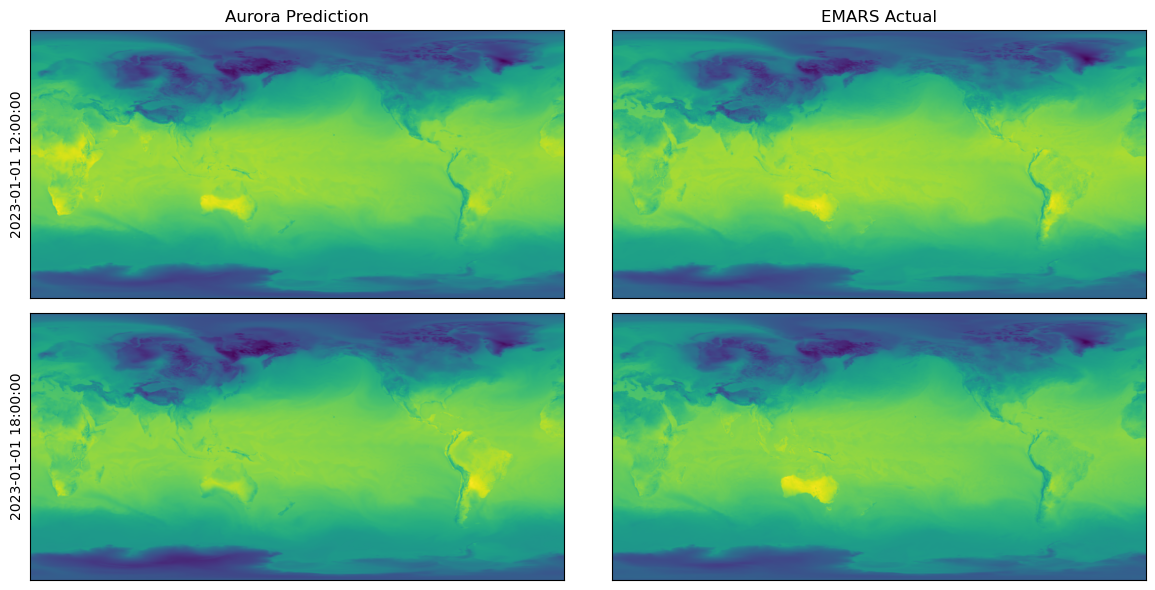

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].imshow(surf_vars_ds["t2m"][i].values - 273.15)
    if i == 0:
        ax[i, 1].set_title("ERA5 Actual")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()